In [1]:
#ライブラリ読み込み
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import random

In [2]:
#アミノ酸配列をone_hot vectorに変換する関数
def one_hot(sequences):
    '''
    https://github.com/kundajelab/dragonn/blob/master/dragonn/utils.py
    '''
    
    
    
    sequence_length = len(sequences[0])
    integer_type = np.int32  # depends on Python version
    integer_array = LabelEncoder().fit(np.array(('ACDEFGHIKLMNPQRSTVWY',)).view(integer_type)).transform(sequences.view(integer_type)).reshape(len(sequences), sequence_length)
    one_hot_encoding = OneHotEncoder(sparse=False, n_values=20, dtype=integer_type).fit_transform(integer_array)
    one_hot_encoding = one_hot_encoding.reshape(len(sequences), 1, sequence_length, 20)[:,0,:,:] # (100, 1, 10, 20)
    return one_hot_encoding

peptide=[]
peptide.append("ARNDCED")
peptide=np.array(peptide)
print(one_hot(peptide).shape)

(1, 7, 20)


In [3]:
#ランダムなペプチド配列を生成する関数
def peptide_sequence_generator(length, embed = False):
    def create():
        peptide=""
        amino_acid =['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
        for i in range(length):
            peptide += random.choice(amino_acid)
        return peptide
    def embed_motif(sequence, motif, position):
        embeded = sequence[:position] + motif + sequence[position + 2:]
        return embeded
    
    peptide = create()
    #sequenceにVVが入っている場合、生成しなおす。
    while peptide.find('VV')>-1:
        peptide =""
        peptide = create()       
    
    #VVを埋め込む
    if embed == True:
        peptide = embed_motif(peptide,"VV",random.randint(0,length-2))
    
    return str(peptide)



#VVを持たない（easy to synthesize, label =0)を50配列。VVを持つ（hard to synthesize, label =1)をシミュレーションする
easy = []
hard = []
labels = []
for i in range(50):
    seq = peptide_sequence_generator(10)
    easy.append(seq)
    labels.append([0.])
for i in range(50):
    seq = peptide_sequence_generator(10,embed=True)
    hard.append(seq)
    labels.append([1.])

easy = np.array(easy)
hard = np.array(hard)
labels = np.array(labels)
peptide_sequences = np.r_[easy,hard]
oh_sequences = one_hot(peptide_sequences)
print(oh_sequences.shape)

(100, 10, 20)


In [4]:
#作成した中身を確認してみる
print (peptide_sequences[0])
print (oh_sequences[0])

FQYCTLSHIW
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


In [5]:
#DLモデルに使用するライブラリ
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D,MaxPool1D,Dropout,Flatten


Using TensorFlow backend.


In [8]:
#モデル構築。簡略ver.　poolingを10にして、モチーフディテクター的な使い方を目的にしてます。
#基本こちらでいけますが、deeplift非対応なモデルのため、次のブロックで同じモデルを書き直しています
model = Sequential()
model.add(Conv1D(filters=20,kernel_size=3,strides=1,padding='same',input_shape=(10,20)))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=10))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(20,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, name='pre-prediction'))
model.add(Activation('sigmoid', name='prediction'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 20)            1220      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 20)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 20)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
__________

In [9]:
#keras with functional api
#deeplift対応モデル（＊それでもなお、deepliftのカスタマイズが必要です。）

from keras.layers import Input, Lambda, Layer, Conv1D, MaxPooling1D, Flatten,Dropout,Dense,concatenate,Reshape,Permute,Activation
from keras.models import Model
main_input = Input(shape=(10,20),name='input')
x = Conv1D(filters=20,
           kernel_size=3,
           strides=1,
           padding='same',
           )(main_input)
x = Activation('relu')(x)
x = MaxPooling1D(pool_size=10)(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(20,activation='relu')(x)
x = Dense(1,name='pre-prediction')(x)
main_output = Activation('sigmoid',name='prediction')(x)
model = Model(inputs=[main_input],outputs=[main_output])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 20)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 20)            1220      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 20)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 20)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
__________

In [10]:
#学習
history = model.fit(x=oh_sequences,y=labels,validation_split=0.2,epochs=200,batch_size=50)

Train on 80 samples, validate on 20 samples
Epoch 1/200
80/80 [==============================] - 0s - loss: 0.6895 - acc: 0.5625 - val_loss: 0.7157 - val_acc: 0.0000e+00
Epoch 2/200
80/80 [==============================] - 0s - loss: 0.6856 - acc: 0.6500 - val_loss: 0.7242 - val_acc: 0.0000e+00
Epoch 3/200
80/80 [==============================] - 0s - loss: 0.6821 - acc: 0.5750 - val_loss: 0.7333 - val_acc: 0.0000e+00
Epoch 4/200
80/80 [==============================] - 0s - loss: 0.6792 - acc: 0.6000 - val_loss: 0.7423 - val_acc: 0.0000e+00
Epoch 5/200
80/80 [==============================] - 0s - loss: 0.6708 - acc: 0.6375 - val_loss: 0.7512 - val_acc: 0.0000e+00
Epoch 6/200
80/80 [==============================] - 0s - loss: 0.6646 - acc: 0.6375 - val_loss: 0.7613 - val_acc: 0.0000e+00
Epoch 7/200
80/80 [==============================] - 0s - loss: 0.6644 - acc: 0.6250 - val_loss: 0.7723 - val_acc: 0.0000e+00
Epoch 8/200
80/80 [==============================] - 0s - loss: 0.6582 - a

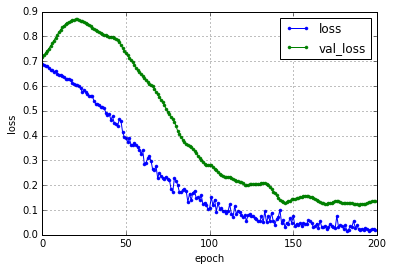

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

#損失を描画
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

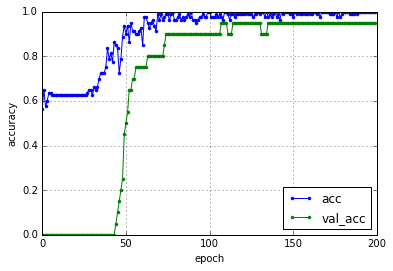

In [46]:
#正答率を描画
loss = history.history['acc']
val_loss = history.history['val_acc']
epochs = len(loss)
plt.plot(range(epochs),loss, marker='.', label='acc')
plt.plot(range(epochs), val_loss, marker='.', label='val_acc')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


In [31]:
#deeplift ライブラリによるシーケンス可視化
#deepliftは最新版のkerasに対応していないので、カスタマイズしてあり、公式版では下記コードを実行できません。
#詳細は戸田まで。
import deeplift
import deeplift.conversion.keras_conversion as kc



deeplift_model = kc.convert_functional_model(
                    model,
                    nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)
#The syntax below for obtaining scores is similar to that of a converted graph model
#See deeplift_model.get_name_to_blob().keys() to see all the layer names
#As before, you can provide an array of names to find_scores_layer_name
#to get the scores for multiple layers at once
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
    find_scores_layer_name="input",
    pre_activation_target_layer_name="pre-prediction")



scores = np.array(deeplift_contribs_func(task_idx=0,
                                         input_data_list=[oh_sequences],
                                         batch_size=10,
                                         progress_update=1))

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
returning 20 1 1
For layer activation_2 the preceding linear layer is conv1d_2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
pool1d, 20 10 1
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer dense_2 the preceding linear layer is preact_dense_2 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
For layer prediction the preceding linear layer is pre-prediction of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
No reference provided - using zeros
Done 0
Done 10
Done 20
D

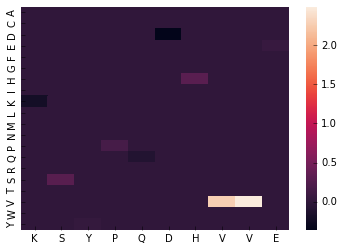

In [51]:
import seaborn as sns
xlabel=[]
for letter in peptide_sequences[50]:
    xlabel.append(letter)
aa = "ACDEFGHIKLMNPQRSTVWY"
ylabel=[]
for letter in aa:
    ylabel.append(letter)
sns.heatmap(scores[50].T,xticklabels=xlabel,yticklabels=ylabel)